In [ ]:
!pip install fastavro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note that `output_A.avro` is a smaller file with lesser songs; while `output_A2Z.avro` contains all available songs.

Since the result is good using `output_A.avro` that contains partial data. Let's move on to the full dataset in `output_A2Z.avro`.

Mean Squared Error: 154.40
Mean Absolute Error: 8.49 years
R-squared: 0.79


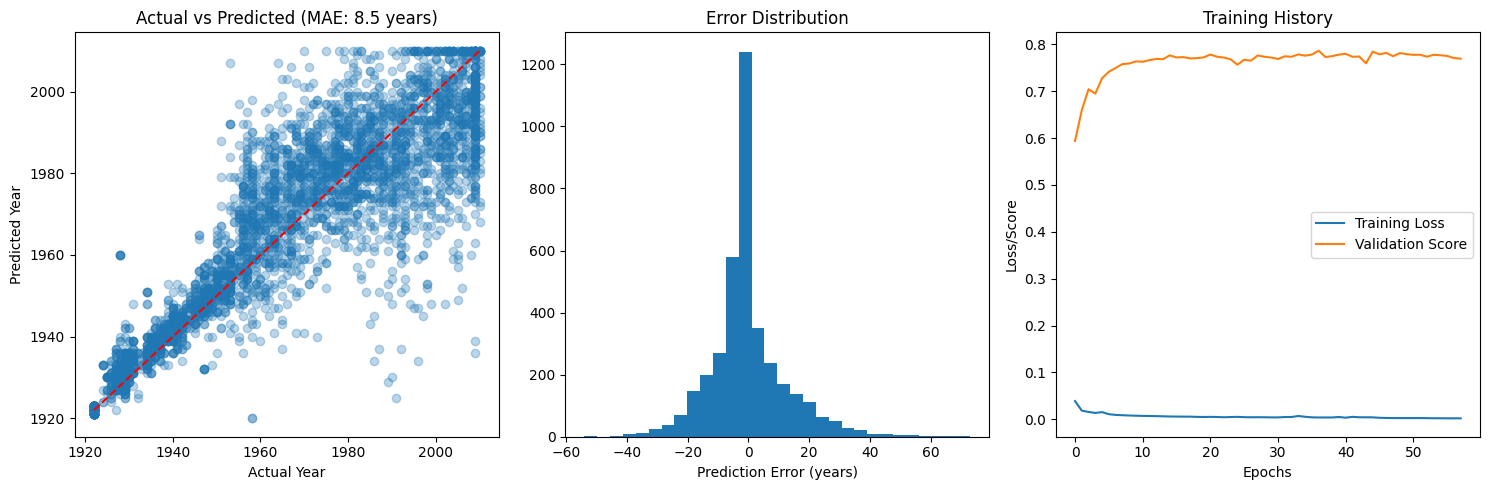

In [ ]:
import fastavro
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample  # This was missing
import matplotlib.pyplot as plt

def load_specific_columns(file_path, columns_needed):
    """Load only specific columns from avro file"""
    data = []
    with open(file_path, 'rb') as f:
        avro_reader = fastavro.reader(f)
        for record in avro_reader:
            filtered_record = {col: record[col] for col in columns_needed}
            data.append(filtered_record)
    df = pd.DataFrame(data)
    df = df[(df['year'] != 0) & (df['year'].notna())]
    return df

# Load the data
needed_columns = ['segments_timbre', 'year']
filtered_data = load_specific_columns('/content/drive/MyDrive/output_A2Z.avro', needed_columns)

# Prepare features and target
timbre_features = pd.DataFrame(filtered_data['segments_timbre'].tolist(),
                            columns=[f'timbre_{i}' for i in range(90)])
years = filtered_data['year'].astype(float)

# Data Balancing Function
def balance_data(X, y, target_range=(1924, 2010), bin_size=5, samples_per_bin=1000):
    """Resample data to balance year distribution"""
    bins = np.arange(target_range[0], target_range[1] + bin_size, bin_size)
    y_binned = np.digitize(y, bins)

    balanced_X = []
    balanced_y = []

    for bin_num in np.unique(y_binned):
        idx = np.where(y_binned == bin_num)[0]

        if len(idx) > samples_per_bin:
            idx = np.random.choice(idx, samples_per_bin, replace=False)
        else:
            idx = resample(idx, replace=True, n_samples=samples_per_bin, random_state=42)

        balanced_X.append(X.iloc[idx])
        balanced_y.append(y.iloc[idx])

    return pd.concat(balanced_X), pd.concat(balanced_y)

# Balance the dataset
X_balanced, y_balanced = balance_data(timbre_features, years)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42)

# Feature Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.base import BaseEstimator, RegressorMixin

class ConstrainedMLP(BaseEstimator, RegressorMixin):
  #  Create a custom output layer using sigmoid scaling
    def __init__(self, min_year=1924, max_year=2010, **mlp_kwargs):
        self.min_year = min_year
        self.max_year = max_year
        self.mlp = MLPRegressor(**mlp_kwargs)

    def fit(self, X, y):
        # Scale y to [0,1] range for sigmoid output
        self.y_min_, self.y_max_ = self.min_year, self.max_year
        y_scaled = (y - self.y_min_) / (self.y_max_ - self.y_min_)
        self.mlp.fit(X, y_scaled)
         # Expose training history attributes
        self.loss_curve_ = self.mlp.loss_curve_
        if hasattr(self.mlp, 'validation_scores_'):
            self.validation_scores_ = self.mlp.validation_scores_
        return self

    def predict(self, X, return_float=False):
        """Returns integer predictions by default"""
        y_pred_scaled = self.mlp.predict(X)
        y_pred = y_pred_scaled * (self.max_year - self.min_year) + self.min_year
        y_pred = np.clip(y_pred, self.min_year, self.max_year)
        return y_pred if return_float else np.ceil(y_pred).astype(int)

# Enhanced MLP Model
mlp = ConstrainedMLP(
    min_year=1920,
    max_year=2010,
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)

mlp.fit(X_train_scaled, y_train)

# Evaluation
# Get integer predictions
y_pred_int = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_int)
mae = mean_absolute_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# 10. Visualization
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_int, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred_int
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_curve_, label='Training Loss')
if hasattr(mlp, 'validation_scores_'):
    plt.plot(mlp.validation_scores_, label='Validation Score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Score')
plt.title('Training History')

plt.tight_layout()
plt.show()

It is expected the MSE is bigger than the one using `output_A.avro`.

We should try modify the model architecture. Let's set the hidden layer from (128, 64, 32) to (1024, 512, 512, 256, 256, 128, 64, 32).

Mean Squared Error: 117.11
Mean Absolute Error: 6.39 years
R-squared: 0.84


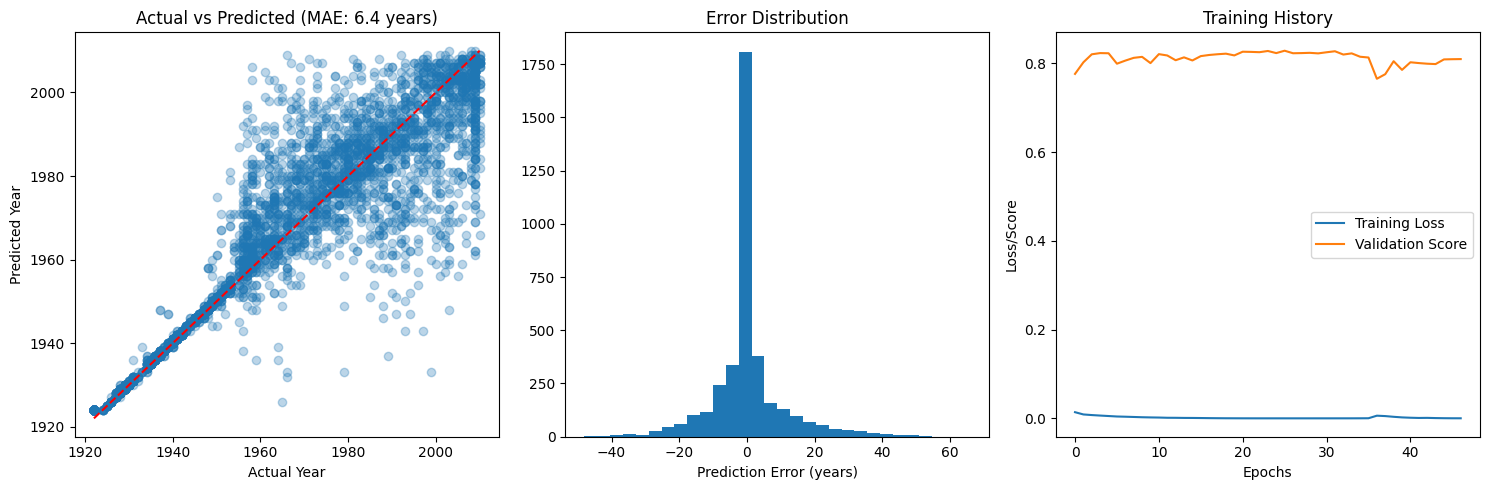

In [ ]:
# Enhanced MLP Model
mlp = ConstrainedMLP(
    min_year=1924,
    max_year=2010,
    hidden_layer_sizes=(1024, 512, 512, 256, 256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.00001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)

mlp.fit(X_train_scaled, y_train)

# Evaluation
# Get integer predictions
y_pred_int = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_int)
mae = mean_absolute_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# Visualization
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_int, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred_int
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_curve_, label='Training Loss')
if hasattr(mlp, 'validation_scores_'):
    plt.plot(mlp.validation_scores_, label='Validation Score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Score')
plt.title('Training History')

plt.tight_layout()
plt.show()

Increasing the hidden layer helps minimizing MSE.

 Let's set the hidden layer from (1024, 512, 512, 256, 256, 128, 64, 32) to (1024, 1024, 512, 256, 256, 128, 64, 32). That is, we increase the number of neurons in one layer.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Mean Squared Error: 129.70
Mean Absolute Error: 7.01 years
R-squared: 0.82


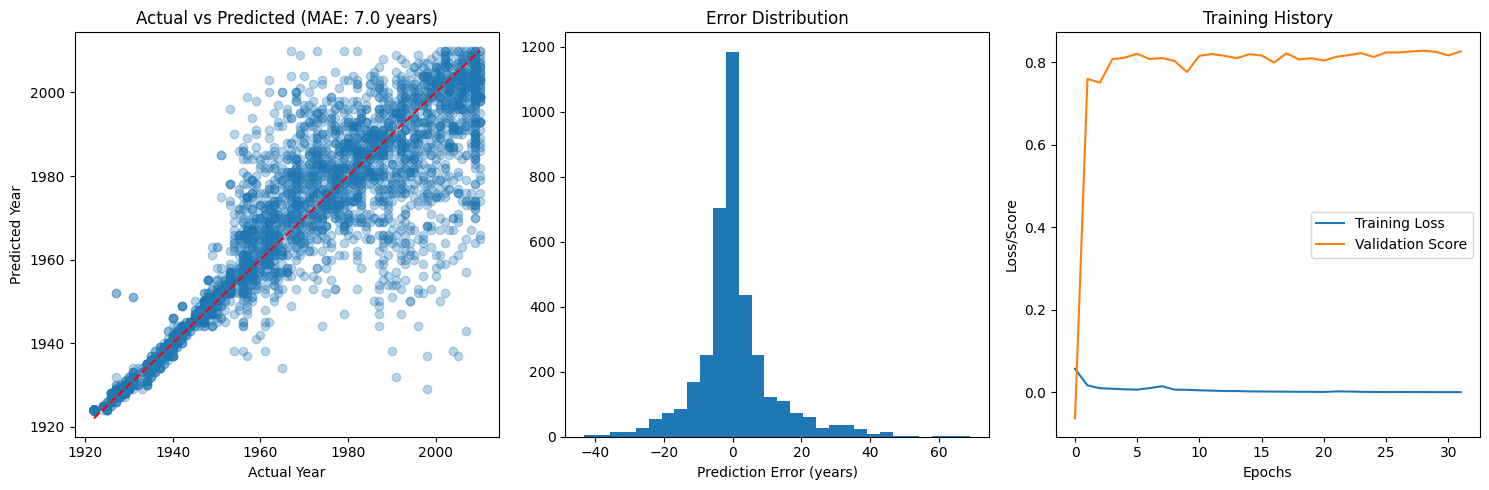

In [ ]:
# Enhanced MLP Model
mlp = ConstrainedMLP(
    min_year=1924,
    max_year=2010,
    hidden_layer_sizes=(1024, 1024, 512, 256, 256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.00001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)

mlp.fit(X_train_scaled, y_train)

y_pred_int = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_int)
mae = mean_absolute_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# 10. Visualization
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_int, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred_int
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_curve_, label='Training Loss')
if hasattr(mlp, 'validation_scores_'):
    plt.plot(mlp.validation_scores_, label='Validation Score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Score')
plt.title('Training History')

plt.tight_layout()
plt.show()

Increasing the neuron doesn't help.

To further minimize the MSE, I tried different data balancing method based on the some intervals of era since the data spread more widely after 1950.

Mean Squared Error: 117.51
Mean Absolute Error: 6.46 years
R-squared: 0.75


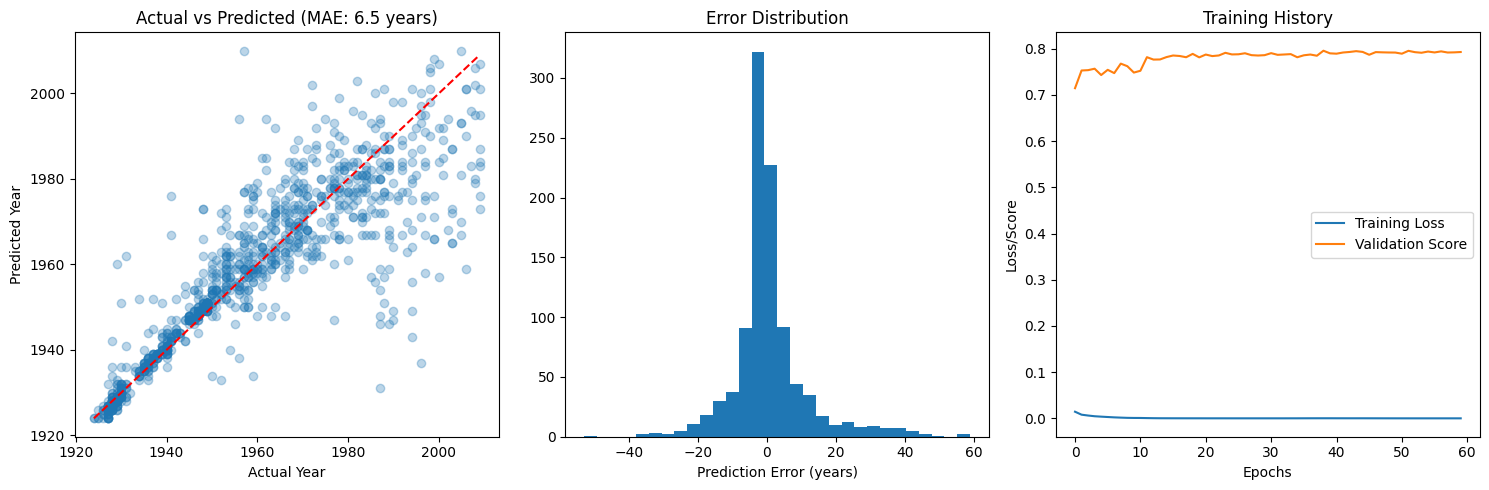

In [ ]:
# Load the data
needed_columns = ['segments_timbre', 'year']
filtered_data = load_specific_columns('/content/drive/MyDrive/output_A2Z.avro', needed_columns)

# Prepare features and target
timbre_features = pd.DataFrame(filtered_data['segments_timbre'].tolist(),
                            columns=[f'timbre_{i}' for i in range(90)])
years = filtered_data['year'].astype(float)

# Data Balancing Function
def balance_data(X, y, era_breakpoints=[1924, 1950, 1970, 1990, 2010],
                samples_per_era=[2000, 1500, 1000, 500], bin_size=5):
    """
    Balanced sampling with era-aware stratification
    Args:
        era_breakpoints: List of year boundaries defining eras
        samples_per_era: Target samples per era (length should be era_breakpoints-1)
        bin_size: Year bin size within eras
    """
    # Reset indices to ensure alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    # Create era masks
    era_masks = [
        (y >= era_breakpoints[i]) & (y < era_breakpoints[i+1])
        for i in range(len(era_breakpoints)-1)
    ]

    balanced_X, balanced_y = [], []

    for i, (era_mask, era_samples) in enumerate(zip(era_masks, samples_per_era)):
        # Get indices where era_mask is True
        era_indices = np.where(era_mask)[0]
        X_era = X.iloc[era_indices]
        y_era = y.iloc[era_indices]

        # Bin within each era
        bins = np.arange(
            era_breakpoints[i],
            era_breakpoints[i+1] + bin_size,
            bin_size
        )
        y_binned = np.digitize(y_era, bins)

        # Calculate samples per bin for this era
        bins_in_era = len(bins) - 1
        samples_per_bin = max(50, era_samples // bins_in_era)  # At least 50 per bin

        for bin_num in np.unique(y_binned):
            idx = np.where(y_binned == bin_num)[0]

            if len(idx) > samples_per_bin:
                selected_idx = np.random.choice(idx, samples_per_bin, replace=False)
            else:
                selected_idx = resample(idx, replace=True,
                                     n_samples=samples_per_bin,
                                     random_state=42)

            balanced_X.append(X_era.iloc[selected_idx])
            balanced_y.append(y_era.iloc[selected_idx])

    return pd.concat(balanced_X), pd.concat(balanced_y)

# Balance the dataset
X_balanced, y_balanced = balance_data(timbre_features, years)

# rain-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42)

# Feature Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = ConstrainedMLP(
    min_year=1924,
    max_year=2010,
    hidden_layer_sizes=(1024, 512, 512, 256, 256, 128, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.00001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)

mlp.fit(X_train_scaled, y_train)
y_pred_int = mlp.predict(X_test_scaled)
accuracy = np.sum(y_pred_int==y_test)
mse = mean_squared_error(y_test, y_pred_int)
mae = mean_absolute_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# 10. Visualization
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_int, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred_int
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_curve_, label='Training Loss')
if hasattr(mlp, 'validation_scores_'):
    plt.plot(mlp.validation_scores_, label='Validation Score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Score')
plt.title('Training History')

plt.tight_layout()
plt.show()

This new data balancing method doesn't outperform the current best (Mean Absolute Error: 6.39 years, R-squared: 0.84).

In fact, I tried to include data from `segments_pitches` for year prediction but the data are too much and run out of memory so the process get killed at the end.

Let's try PCA on the 180 features of `segments_timbre` and `segments_pitches`.

Loading data...
Preparing features...
Balancing data...
Splitting data...
Scaling and reducing dimensions...
Original features: 180
Reduced components: 150


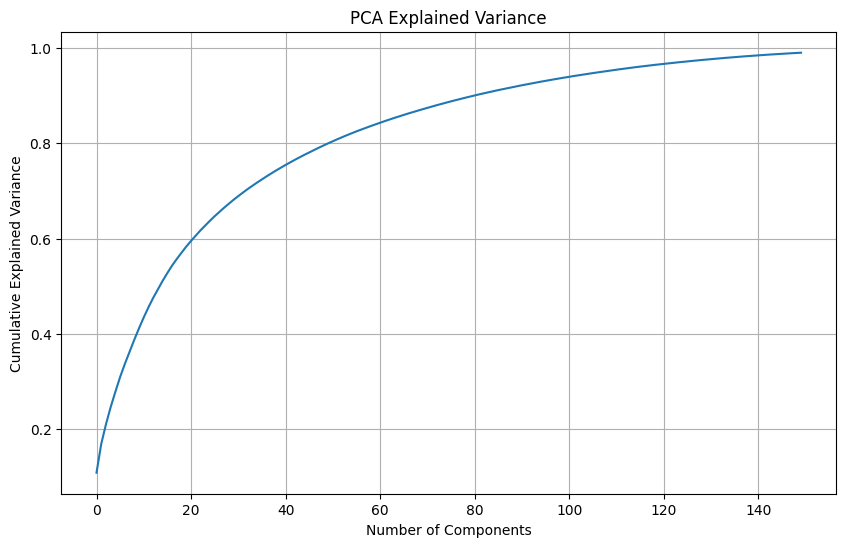

Training model...
Evaluating model...

Model Performance:
Accuracy: 6.63%
Mean Squared Error: 157.43
Mean Absolute Error: 8.45 years
R-squared: 0.78
Creating visualizations...


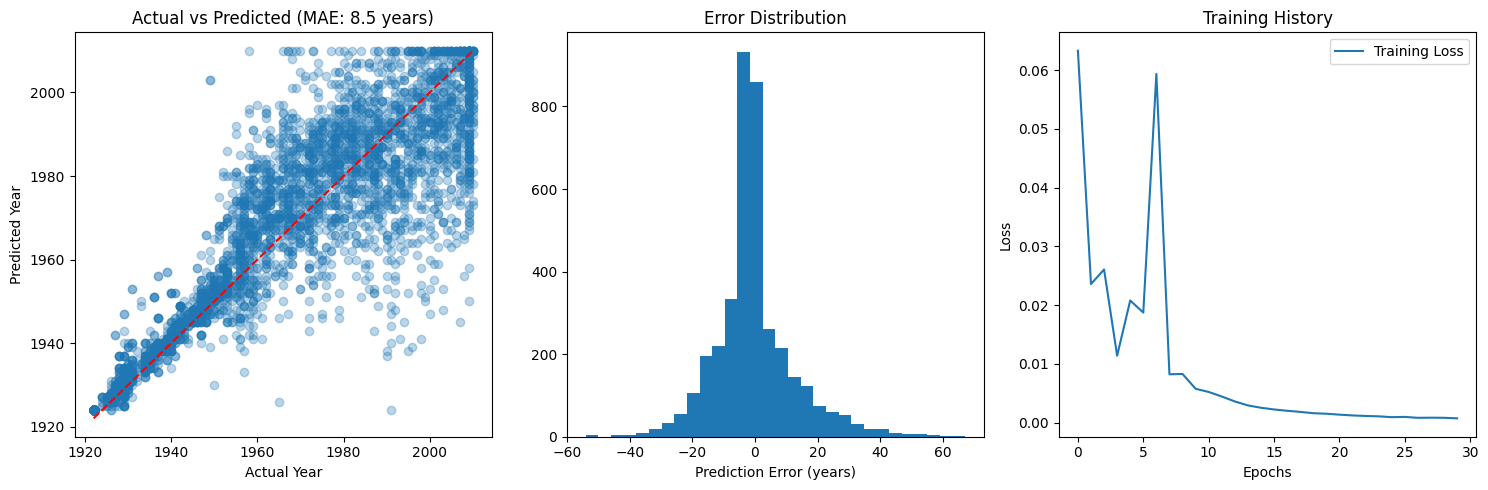

In [ ]:
from sklearn.decomposition import IncrementalPCA  # Changed to memory-efficient PCA
import gc  # For manual garbage collection

# Data Loading with Memory Optimization
def load_specific_columns(file_path, columns_needed, chunk_size=10000):
    """Load data in chunks to manage memory"""
    chunks = []
    with open(file_path, 'rb') as f:
        avro_reader = fastavro.reader(f)
        chunk = []
        for i, record in enumerate(avro_reader):
            filtered_record = {col: record[col] for col in columns_needed}
            chunk.append(filtered_record)
            if (i + 1) % chunk_size == 0:
                chunks.append(pd.DataFrame(chunk))
                chunk = []
        if chunk:  # Add the last partial chunk
            chunks.append(pd.DataFrame(chunk))
    return pd.concat(chunks).reset_index(drop=True)

# Load the data in chunks
needed_columns = ['segments_timbre', 'segments_pitches', 'year']
print("Loading data...")
filtered_data = load_specific_columns('/content/drive/MyDrive/output_A2Z.avro', needed_columns)
filtered_data = filtered_data[(filtered_data['year'] != 0) & (filtered_data['year'].notna())]

# Prepare features with memory efficiency
print("Preparing features...")
def create_features(df):
    timbre = pd.DataFrame(df['segments_timbre'].tolist(), columns=[f'timbre_{i}' for i in range(90)])
    pitches = pd.DataFrame(df['segments_pitches'].tolist(), columns=[f'pitch_{i}' for i in range(90)])
    return pd.concat([timbre, pitches], axis=1)

# Process in chunks if memory is tight
X = create_features(filtered_data)
y = filtered_data['year'].astype(float)

# Free up memory
del filtered_data
gc.collect()

# Data Balancing with Sampling
print("Balancing data...")
def balance_data(X, y, target_range=(1924, 2010), bin_size=5, samples_per_bin=1000):
    bins = np.arange(target_range[0], target_range[1] + bin_size, bin_size)
    y_binned = np.digitize(y, bins)

    balanced_indices = []
    for bin_num in np.unique(y_binned):
        idx = np.where(y_binned == bin_num)[0]
        if len(idx) > samples_per_bin:
            idx = np.random.choice(idx, samples_per_bin, replace=False)
        else:
            idx = resample(idx, replace=True, n_samples=samples_per_bin, random_state=42)
        balanced_indices.extend(idx)

    return X.iloc[balanced_indices], y.iloc[balanced_indices]

X_balanced, y_balanced = balance_data(X, y)

# Free up memory
del X, y
gc.collect()

# Train-Test Split
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42)

# Memory-Efficient Feature Processing
print("Scaling and reducing dimensions...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use IncrementalPCA for memory efficiency
ipca = IncrementalPCA(n_components=150, batch_size=1000)
X_train_pca = ipca.fit_transform(X_train_scaled)
X_test_pca = ipca.transform(X_test_scaled)

print(f"Original features: {X_train.shape[1]}")
print(f"Reduced components: {X_train_pca.shape[1]}")
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(ipca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Free up memory
del X_train_scaled, X_test_scaled
gc.collect()

from sklearn.base import BaseEstimator, RegressorMixin

# 6. Optimized MLP Model
print("Training model...")
class ConstrainedMLP(BaseEstimator, RegressorMixin):
    def __init__(self, min_year=1924, max_year=2010, **mlp_kwargs):
        self.min_year = min_year
        self.max_year = max_year
        self.mlp = MLPRegressor(**mlp_kwargs)

    def fit(self, X, y):
        y_scaled = (y - self.min_year) / (self.max_year - self.min_year)
        self.mlp.fit(X, y_scaled)
        self.loss_curve_ = self.mlp.loss_curve_
        return self

    def predict(self, X, return_float=False):
        y_pred_scaled = self.mlp.predict(X)
        y_pred = y_pred_scaled * (self.max_year - self.min_year) + self.min_year
        y_pred = np.clip(y_pred, self.min_year, self.max_year)
        return y_pred if return_float else np.ceil(y_pred).astype(int)

mlp = ConstrainedMLP(
    min_year=1924,
    max_year=2010,
    hidden_layer_sizes=(256, 128, 64),  # Reduced architecture
    activation='relu',
    solver='adam',
    alpha=0.0001,  # Increased regularization
    batch_size=256,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=500,  # Reduced iterations
    random_state=42,
    n_iter_no_change=15
)

mlp.fit(X_train_pca, y_train)

# 7. Evaluation
print("Evaluating model...")
y_pred_int = mlp.predict(X_test_pca)

accuracy = np.sum(y_pred_int == y_test) / len(y_test)
mse = mean_squared_error(y_test, y_pred_int)
mae = mean_absolute_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# 8. Visualizations
print("Creating visualizations...")
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_int, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred_int
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')

plt.tight_layout()
plt.show()

Let's see how well using `segments_pitches` work alone.

Mean Squared Error: 160.37
Mean Absolute Error: 8.24 years
R-squared: 0.78


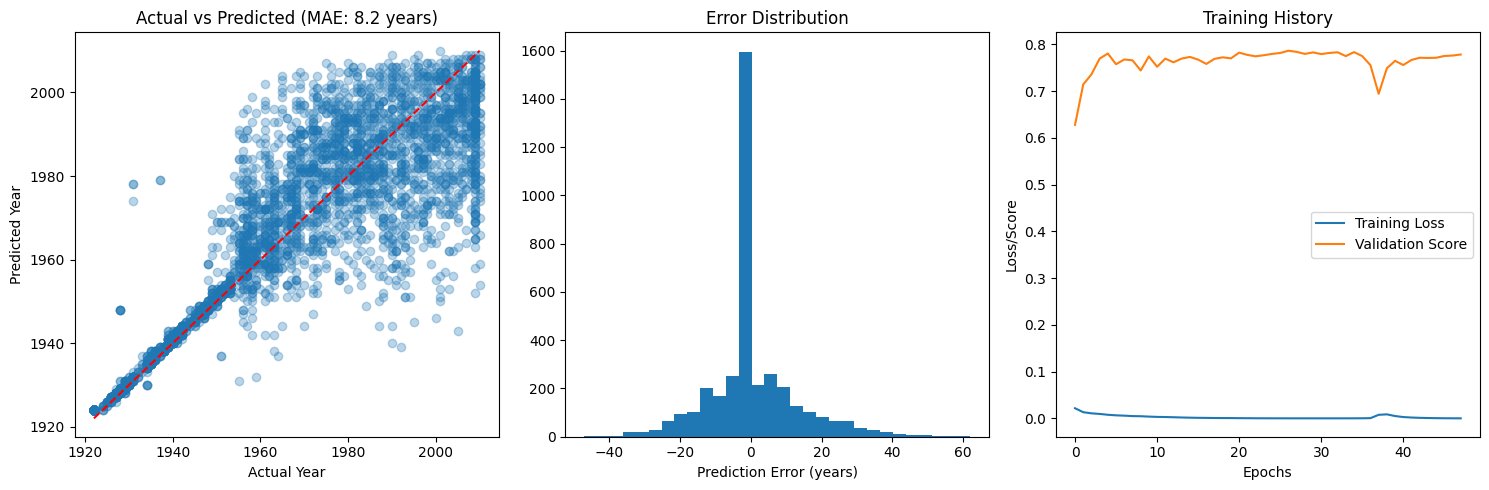

In [ ]:
import fastavro
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample  # This was missing
import matplotlib.pyplot as plt

def load_specific_columns(file_path, columns_needed):
    """Load only specific columns from avro file"""
    data = []
    with open(file_path, 'rb') as f:
        avro_reader = fastavro.reader(f)
        for record in avro_reader:
            filtered_record = {col: record[col] for col in columns_needed}
            data.append(filtered_record)
    df = pd.DataFrame(data)
    df = df[(df['year'] != 0) & (df['year'].notna())]
    return df

# Load the data
needed_columns = ['segments_pitches', 'year']
filtered_data = load_specific_columns('/content/drive/MyDrive/output_A2Z.avro', needed_columns)

# 2. Prepare features and target
timbre_features = pd.DataFrame(filtered_data['segments_pitches'].tolist(),
                            columns=[f'timbre_{i}' for i in range(90)])
years = filtered_data['year'].astype(float)

# 3. Data Balancing Function
def balance_data(X, y, target_range=(1924, 2010), bin_size=5, samples_per_bin=1000):
    """Resample data to balance year distribution"""
    bins = np.arange(target_range[0], target_range[1] + bin_size, bin_size)
    y_binned = np.digitize(y, bins)

    balanced_X = []
    balanced_y = []

    for bin_num in np.unique(y_binned):
        idx = np.where(y_binned == bin_num)[0]

        if len(idx) > samples_per_bin:
            idx = np.random.choice(idx, samples_per_bin, replace=False)
        else:
            idx = resample(idx, replace=True, n_samples=samples_per_bin, random_state=42)

        balanced_X.append(X.iloc[idx])
        balanced_y.append(y.iloc[idx])

    return pd.concat(balanced_X), pd.concat(balanced_y)

# 4. Balance the dataset
X_balanced, y_balanced = balance_data(timbre_features, years)

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42)

# 6. Feature Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.base import BaseEstimator, RegressorMixin

class ConstrainedMLP(BaseEstimator, RegressorMixin):
  #  Create a custom output layer using sigmoid scaling
    def __init__(self, min_year=1924, max_year=2010, **mlp_kwargs):
        self.min_year = min_year
        self.max_year = max_year
        self.mlp = MLPRegressor(**mlp_kwargs)

    def fit(self, X, y):
        # Scale y to [0,1] range for sigmoid output
        self.y_min_, self.y_max_ = self.min_year, self.max_year
        y_scaled = (y - self.y_min_) / (self.y_max_ - self.y_min_)
        self.mlp.fit(X, y_scaled)

         # Expose training history attributes
        self.loss_curve_ = self.mlp.loss_curve_
        if hasattr(self.mlp, 'validation_scores_'):
            self.validation_scores_ = self.mlp.validation_scores_
        return self

    def predict(self, X, return_float=False):
        """Returns integer predictions by default"""
        y_pred_scaled = self.mlp.predict(X)
        y_pred = y_pred_scaled * (self.max_year - self.min_year) + self.min_year
        y_pred = np.clip(y_pred, self.min_year, self.max_year)
        return y_pred if return_float else np.ceil(y_pred).astype(int)

# 7. Enhanced MLP Model
mlp = ConstrainedMLP(
    min_year=1924,
    max_year=2010,
    hidden_layer_sizes=(1024, 512, 512, 256, 256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.00001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.20,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)

mlp.fit(X_train_scaled, y_train)

# 9. Evaluation
# y_pred = mlp.predict(X_test_scaled)

# Get integer predictions
y_pred_int = mlp.predict(X_test_scaled)

accuracy = np.sum(y_pred_int==y_test)

# # If you ever need float predictions (e.g., for analysis)
# y_pred_float = mlp.predict(X_test_scaled, return_float=True)

mse = mean_squared_error(y_test, y_pred_int)
mae = mean_absolute_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# 10. Visualization
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_int, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred_int
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_curve_, label='Training Loss')
if hasattr(mlp, 'validation_scores_'):
    plt.plot(mlp.validation_scores_, label='Validation Score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Score')
plt.title('Training History')

plt.tight_layout()
plt.show()

Seems like using `segments_pitches` alone is not any better than using `segments_timbre` alone.

With scikit-learn MLPRegressor, the best result is:

Mean Squared Error: 117.11

Mean Absolute Error: 6.39 years

R-squared: 0.84

with no PCA applied, using only `segments_timbre`. 

In [ ]:
'''
mlp = ConstrainedMLP(
    min_year=1924,
    max_year=2010,
    hidden_layer_sizes=(1024, 512, 512, 256, 256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.00001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)
'''